In [12]:
import pandas as pd
import numpy as np
import timeit

In [6]:
df = pd.read_csv("train.csv", index_col=[0])

In [7]:
r_masks = [
    ["zoning", df["MSZoning"] == "RM"],
    ["lotconfig", df["LotConfig"].isin(["Inside", "FR2"])],
    ["lotarea", (df["LotArea"] > 8000) & (df["LotArea"] < 12_000)]
]

In [19]:
def vectorised_filter(df, input_masks):
    # stack filters into a vector
    masks = [mask for _, mask in input_masks]
    vectored_masks = np.column_stack(masks)

    # calculate how many rowss are removed in each filter (absolute comparison)
    abs_removed = - ((np.sum(vectored_masks, axis=0) - np.size(df, axis=0)) / np.size(df, axis=0) * 100)
        
    # record removal stats in a dict
    filter_stats = {
        name: {
            "absolute": absolute,
            "relative": 0,
        } 
        for name, absolute in zip([name for name, _ in r_masks], - abs_removed)
    }
    
    # calculate how many rows are removed in each filter (relative comparison)
    counter = 1
    previous_feature = None
    for name, _ in r_masks:
        cum_mask = np.logical_and.reduce(vectored_masks[:,:counter], axis=1).sum()
        
        filter_stats[name]["relative"] = (cum_mask - df.shape[0]) / df.shape[0] * 100 if not previous_feature else (cum_mask - previous_remaining) / previous_remaining * 100
        
        previous_remaining = np.logical_and.reduce(vectored_masks[:,:counter], axis=1).sum()
        
        previous_feature = name 
        counter += 1
        
    super_mask = np.logical_and.reduce(masks, axis=0)
    filtered_df = df.loc[super_mask]
    
    return filtered_df, pd.DataFrame(filter_stats).T.round(2)

In [15]:
a, b = vectorised_filter(df, r_masks)

In [10]:
a.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
64,70,RM,50.0,10300,Pave,NaN,IR1,Bnk,AllPub,Inside,...,0,NaN,GdPrv,NaN,0,4,2010,WD,Normal,140000
78,50,RM,50.0,8635,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,MnPrv,NaN,0,1,2008,WD,Normal,127000
107,30,RM,60.0,10800,Pave,Grvl,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,Shed,450,8,2007,WD,Normal,100000
145,90,RM,70.0,9100,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,11,2006,ConLI,Abnorml,125000
180,30,RM,60.0,8520,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,7,2007,WD,Normal,100000


In [11]:
b.head()

,absolute,relative
zoning,-85.07,-85.07
lotconfig,-24.73,-18.35
lotarea,-51.44,-78.65


In [97]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

<Axes: xlabel='perf', ylabel='Density'>

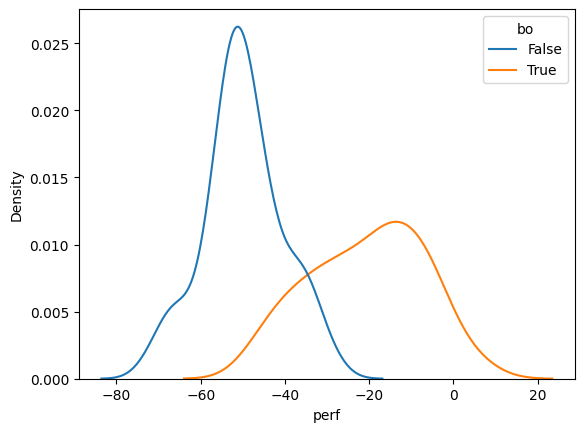

In [208]:
g = 300
f = np.concatenate([np.random.randint(1, 50, g), np.random.randint(1, 100, g)])

idx = ["q1", "q2", "q3", "q4"] * int(f.shape[0] / 4)
df1 = pd.DataFrame(f, index=idx, columns=["count"])

df = pd.concat([df1], keys=["True", "False"])
df["perf"] = np.nan

df["bo"] = np.random.randint(0, 2, f.shape[0])
df["bo"] = df["bo"].astype(bool)


c = df[df["bo"] == False].shape[0]
p = np.random.normal(-50, 10, c)
df.loc[df["bo"] == False, "perf"] = p

c = df[df["bo"] == True].shape[0]
p = np.random.normal(-20, 15, c)
df.loc[df["bo"] == True, "perf"] = p



y = df.loc["True"].reset_index()
y = y[y["index"] == "q1"]


sns.kdeplot(x="perf", data=y, hue="bo")

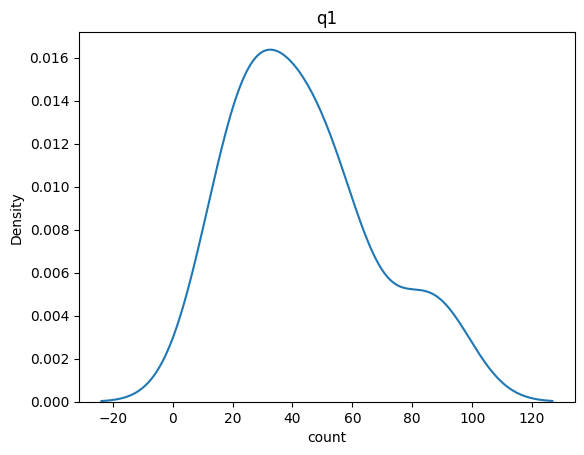

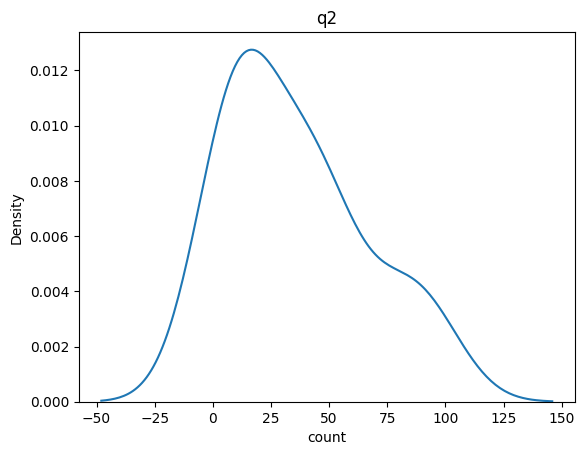

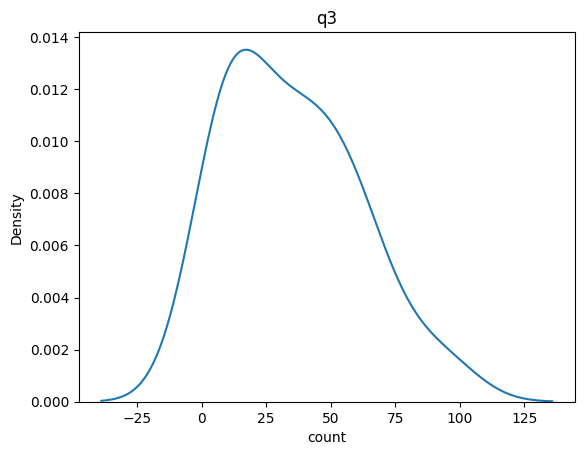

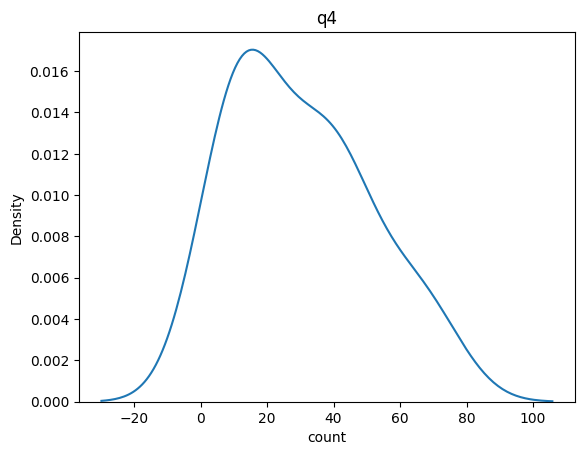

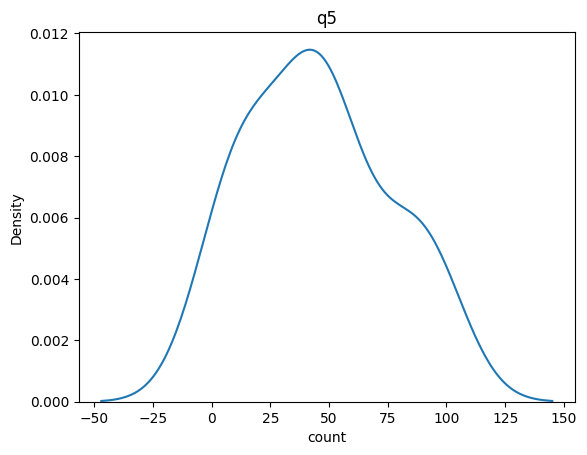

In [103]:
data = df.loc["True"].reset_index()
for i in data["index"].unique():
    plt.title(i)
    sns.kdeplot(data=data[data["index"] == i].reset_index(), x="count")
    plt.show()

<Axes: xlabel='count', ylabel='Density'>

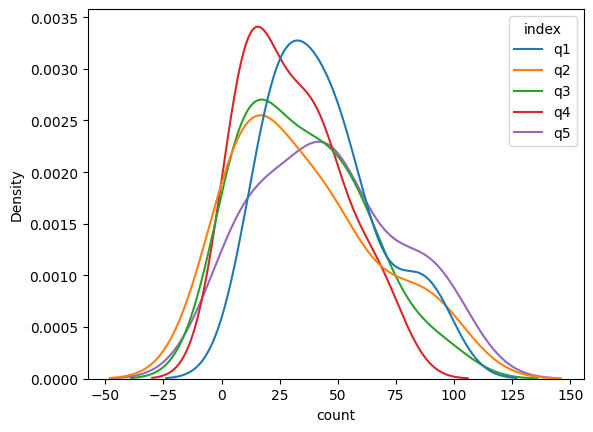

In [104]:
sns.kdeplot(data=data, x="count", hue="index")

In [34]:
(df.loc["True"] / df.loc["True"].sum() * 100).round(2)

,count
q1,25.00
q2,31.25
q3,18.75
q4,6.25
q5,18.75


In [35]:
(df.loc["False"] / df.loc["False"].sum() * 100).round(2)

,count
q1,23.81
q2,4.76
q3,33.33
q4,28.57
q5,9.52
